# KNN model

## Description 
## TBD

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import time
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skimage.transform import resize

import pydicom



In [2]:
#Function to go from numeric label to text label
def n_to_t_label(n_label):
    if n_label == 0:
        t_label = 'noCancer'
    elif n_label == 1:
        t_label = 'withCancer'
    else:
        raise ValueError('Invalid numeric label. Expected 0 or 1, but got {}'.format(n_label))
    return t_label

In [3]:
# upload dataframe with image size information
df = pd.read_csv(r"C:\Users\mandy\Documents\MIDS\W207\W207MammogramProject\ImageMetrics_Subset.csv")

In [4]:
df.head()

,file_name,samp_per_pix,n_rows_image,n_cols_image
0,1459541791.dcm,1,5355,4915
1,1864590858.dcm,1,5355,4915
2,1874946579.dcm,1,5355,4915
3,462822612.dcm,1,5355,4915
4,1031443799.dcm,1,2776,2082


In [5]:
# Load train.csv into a dataframe
# This is metadata provided in addition to the dicom files
# We are doing this to get the labels, cancer 0 or 1
df2 = pd.read_csv(r"F:\rsna-breast-cancer-detection\train.csv")
df2 = df2[['patient_id', 'image_id','cancer'] ]
df2.head()

,patient_id,image_id,cancer
0,10006,462822612,0
1,10006,1459541791,0
2,10006,1864590858,0
3,10006,1874946579,0
4,10011,220375232,0


In [6]:
# We want to join df with df2
# We need to add a column to df2 with filenames to enable the join
df2['file_name'] = df2['image_id'].astype(str) + '.dcm'
df2.head()

,patient_id,image_id,cancer,file_name
0,10006,462822612,0,462822612.dcm
1,10006,1459541791,0,1459541791.dcm
2,10006,1864590858,0,1864590858.dcm
3,10006,1874946579,0,1874946579.dcm
4,10011,220375232,0,220375232.dcm


In [46]:
print('df shape:', df.shape)
print('df2 shape:', df2.shape)

# Join the dataframes on the 'file_name' column
query = '''
SELECT df.file_name,  df2.patient_id, df2.cancer, df.n_rows_image, df.n_cols_image
FROM df
INNER JOIN df2
ON df.file_name = df2.file_name
'''

df_joined = sqldf(query, locals())

# Print the resulting dataframe
print('df_joined shape:', df_joined.shape)
print('df_joined has the same shape as df and df2 as expected. \n')
print('df_joined head:\n', df_joined.head())

# Save dataframe
output_file = "JoinedData1.csv"
df_joined.to_csv(output_file, index=False)
#df_joined = pd.read_csv(r"C:\Users\mandy\Documents\MIDS\W207\W207MammogramProjectJoinedData1.csv")

df shape: (54706, 4)
df2 shape: (54706, 4)
df_joined shape: (54706, 5)
df_joined has the same shape as df and df2 as expected. 

df_joined head:
         file_name  patient_id  cancer  n_rows_image  n_cols_image
0  1459541791.dcm       10006       0          5355          4915
1  1864590858.dcm       10006       0          5355          4915
2  1874946579.dcm       10006       0          5355          4915
3   462822612.dcm       10006       0          5355          4915
4  1031443799.dcm       10011       0          2776          2082


In [8]:
# Filter to only keep images with 4096 x 3328 pixels
df_filtered = df_joined.loc[(df_joined['n_rows_image'] == 4096) & (df_joined['n_cols_image'] == 3328)].reset_index(drop=True)
print('df_filtered shape:', df_filtered.shape, '\n')
print('df_filtered:\n',df_filtered.head())

df_filtered shape: (24109, 5) 

df_filtered:
         file_name  patient_id  cancer  n_rows_image  n_cols_image
0  1007799858.dcm       10097       0          4096          3328
1   166011602.dcm       10097       0          4096          3328
2  1957744616.dcm       10097       0          4096          3328
3   268368896.dcm       10097       0          4096          3328
4   664674273.dcm       10097       0          4096          3328


In [9]:
# Check how many cancer vs no cancer cases we're left with after the filtering
# 600 cancer cases. No cancer is now ~97% of images vs the pre-filter 98%
# conclusion that this filter returns an ok data set, about half of the original and about the same % split outcomes
df_filtered['cancer'].value_counts()

0    23509
1      600
Name: cancer, dtype: int64

In [10]:
#For the purpose of this exercise, I only want one image per patient
# In practice should do 1 image per breast but simplified for this exercise
df_filtered = df_filtered.drop_duplicates(subset=['patient_id'], keep='first').reset_index(drop=True)
df_filtered = df_filtered.set_index('file_name')
print(df_filtered)
print('df_filtered cancer value counts:', df_filtered['cancer'].value_counts())
print('\n98% dataset is positive for cancer')

                patient_id  cancer  n_rows_image  n_cols_image
file_name                                                     
1007799858.dcm       10097       0          4096          3328
1181635673.dcm       10102       0          4096          3328
394215927.dcm        10119       0          4096          3328
1891054212.dcm       10124       0          4096          3328
1035012441.dcm       10126       0          4096          3328
...                    ...     ...           ...           ...
1640274067.dcm        9953       0          4096          3328
2043422318.dcm        9954       0          4096          3328
1731793299.dcm        9955       0          4096          3328
1245697729.dcm        9967       0          4096          3328
2098937312.dcm        9968       0          4096          3328

[5094 rows x 4 columns]
df_filtered cancer value counts: 0    4974
1     120
Name: cancer, dtype: int64

98% dataset is positive for cancer


In [11]:
imageIds = df_filtered.index
print(imageIds)

Index(['1007799858.dcm', '1181635673.dcm', '394215927.dcm', '1891054212.dcm',
       '1035012441.dcm', '1013166704.dcm', '1646384157.dcm', '1520248094.dcm',
       '1280087654.dcm', '1352374842.dcm',
       ...
       '1561108471.dcm', '1991772614.dcm', '1386484611.dcm', '1628036726.dcm',
       '1462675731.dcm', '1640274067.dcm', '2043422318.dcm', '1731793299.dcm',
       '1245697729.dcm', '2098937312.dcm'],
      dtype='object', name='file_name', length=5094)


In [28]:
#Get Data
#X is mammogram images
#y is labels

# Set the directory where your DICOM files are located
dicom_directory = r"F:\rsna-breast-cancer-detection\train_images"

# Initialize list of flattened training images and outcomes
images = []
labels = []

# Set a counter for the number of DICOM files found
count = 0

# Start the timer
start_time = time.time()

# Recursively search for DICOM files in all subdirectories
for root, dirs, files in os.walk(dicom_directory):
    for filename in files:
        # Check if the file is a DICOM file
        if filename.endswith(".dcm"):
            # Check if the file is in the training list
            if (imageIds == filename).any().any():
                #print(filename)
                file_path = os.path.join(root, filename)
                # Add the pixel data to X_train_list
                ds = pydicom.dcmread(file_path)
                pixel_array = ds.pixel_array
                resized_pixel_array = resize(pixel_array, (1024, 832), anti_aliasing=True)
                images.append(resized_pixel_array.flatten())
                # Add the label information
                labels.append(df_filtered.loc[filename,'cancer'])
            # Increment the counter
            count += 1
            if count % 1000 == 0:
                print(f"Processed {count} DICOM files...")
        if count == 10000:
            break
    if count >= 10000:
        break


images = np.array(images)                
# Create a Pandas DataFrame from the list
#X_train = pd.DataFrame(X_train_list)

Processed 1000 DICOM files...
Processed 2000 DICOM files...
Processed 3000 DICOM files...
Processed 4000 DICOM files...
Processed 5000 DICOM files...
Processed 6000 DICOM files...
Processed 7000 DICOM files...
Processed 8000 DICOM files...
Processed 9000 DICOM files...
Processed 10000 DICOM files...


In [45]:
np.savez_compressed('KNN_Xs.npz', data=images)
# Load the compressed array from disk
#images = np.load('KNN_Xs.npz')['images']

In [34]:
print('images.shape:', images.shape)
print('\nnumber of labels:', len(labels))
print('\nnumber of positive cancer cases:', sum(labels))

images.shape: (945, 851968)

number of labels: 945

number of positive cancer cases: 22


In [35]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

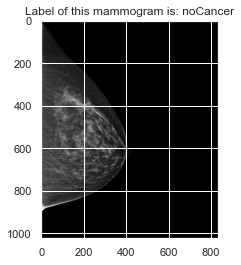

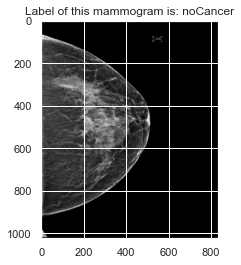

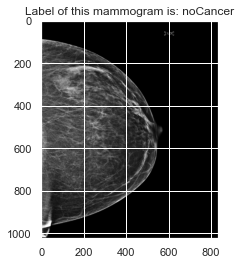

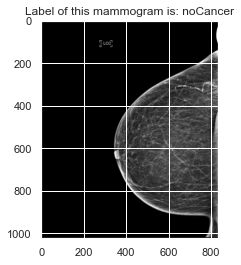

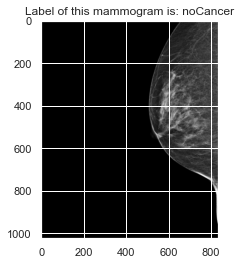

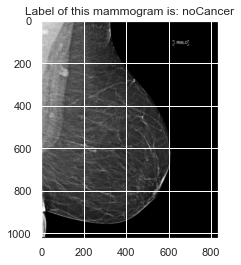

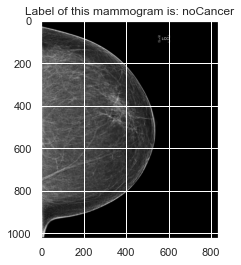

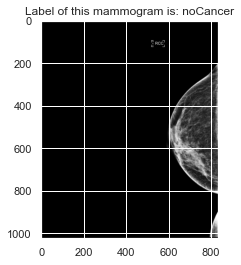

In [36]:
#ONLY use images that are 4096x3328 bu resized by half
#If this changes, change these variables
im_px_1 = 1024
im_px_2 = 832

# Def function to plot a mammogram from a vector
# Label will be 'withCancer' or 'noCancer'
def show_mammogram(x_vec, n_label):
    label = n_to_t_label(n_label)
    x_mat = x_vec.reshape(im_px_1, im_px_2)
    plt.imshow(x_mat, cmap=plt.cm.gray)
    plt.title('Label of this mammogram is: ' + label)
    plt.show()

for i in range(8):
    show_mammogram(X_train[i], y_train[i])


In [37]:
# Train KNN classifier on training set
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
# Step 5: Evaluate performance on test set
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9841269841269841


In [39]:
X_train.shape

(756, 851968)

In [40]:
X_test.shape

(189, 851968)

In [41]:
sum(y_train)

19

In [42]:
sum(y_test)

3